# Problema da Mochila

In [36]:
import random
import copy
import matplotlib.pyplot as plt
import pandas as pd

## Definição do Problema
Você fará uma viagem a um acampamento durante o final de semana e precisa decidir quais itens levar. Como você só dispõe de uma mochila com capacidade para 15 kg, decidiu incluir somente os itens que maximizem a soma do valor em R$ dos itens, sem ultrapassar o limite de peso.  
Resolva o problema utilizando algoritmo genético. Para isso descreva a forma de representação do problema em cromossomos, a função de ajuste (fitness) e os operadores genéticos (mutação, crossover e o mecanismo de seleção).  
Assuma valores razoáveis para os hiperparâmetros comentando a sua escolha. Depois experimente alterá-los e reporte o que acontece

In [37]:
# Criando a classe item para ficar empacotar as informações dos itens e acessar de forma padronizada
class Item:
    def __init__(self, name, weight, value):
        self.name = name
        self.weight = weight
        self.value = value

In [38]:
items = [
    Item("Barraca", 3.5, 150.00),
    Item("Saco de dormir", 2.0, 100.00),
    Item("Isolante térmico", 0.5, 50.00),
    Item("Colchão inflável", 1.0, 80.00),
    Item("Lanterna", 0.2, 30.00),
    Item("Kit de primeiros socorros", 0.5, 20.00),
    Item("Repelente de insetos", 0.1, 15.00),
    Item("Protetor solar", 0.2, 20.00),
    Item("Canivete", 0.1, 10.00),
    Item("Mapa e bússola", 0.3, 25.00),
    Item("Garrafa de água", 1.8, 15.00),
    Item("Filtro de água", 0.5, 50.00),
    Item("Comida (ração liofilizada)", 3.0, 50.00),
    Item("Fogão de camping", 1.5, 70.00),
    Item("Botijão de gás", 1.2, 30.00),
    Item("Prato, talheres e caneca", 0.5, 20.00),
    Item("Roupas (conjunto)", 1.5, 80.00),
    Item("Calçados (botas)", 2.0, 120.00),
    Item("Toalha", 0.5, 20.00),
    Item("Kit de higiene pessoal", 0.5, 30.00)
]

## Cromossomos

Vamos criar o cromossomo como uma classe, onde poderemos definir seu tamanho, dessa forma o tamanho do cromossomo poderá ser utilizado como um hiperparametro.  
Vamos também definir como método uma função fitness, podendo assim calcular qual seu fitness

In [39]:
class Chromosome:
    def __init__(self, items, max_weight, random_state=None):
        self.length = len(items)
        self.items = items
        self.max_weight = max_weight
        self.random_state = random_state
        random.seed(random_state)
        self.genes = [random.randint(0,1) for _ in range(self.length)]

    def get_metrics(self):

        self.weight = sum([self.items[index].weight for index, gene in enumerate(self.genes) if gene == 1])

        if self.weight <= self.max_weight:
            self.fitness = sum([self.items[index].value for index, gene in enumerate(self.genes) if gene == 1])
        else:
            self.fitness = 0

        return self.fitness, self.weight

    # Os métodos abaixo são implementados para facilitar a comparação entre diferentes cromossomos
    def __eq__(self, other):
        if isinstance(other, Chromosome):
            return self.fitness == other.fitness
        return NotImplemented

    def __lt__(self, other):
        if isinstance(other, Chromosome):
            return self.fitness < other.fitness
        return NotImplemented

    def __le__(self, other):
        if isinstance(other, Chromosome):
            return self.fitness <= other.fitness
        return NotImplemented

    def __gt__(self, other):
        if isinstance(other, Chromosome):
            return self.fitness > other.fitness
        return NotImplemented

    def __ge__(self, other):
        if isinstance(other, Chromosome):
            return self.fitness >= other.fitness
        return NotImplemented


In [40]:
# Testando Criação dos Genes e verificando random_state para replicabilidade
print('With random state: ', Chromosome(items, 15, 777).genes)
print('With random state: ', Chromosome(items, 15, 777).genes)
print('Without random state: ', Chromosome(items, 15).genes)
print('Without random state: ', Chromosome(items, 15).genes)

With random state:  [0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0]
With random state:  [0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0]
Without random state:  [0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0]
Without random state:  [0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1]


## Operadores
Agora vamos criar funções capazes de realizar as seguintes ações:  
- Crossover
- Mutação

### Crossover
Na função de crossover implementada estamos utilizando um sorteio com probabildiade de 50% para selecionar quais genes do cromossomo 1 serão trocados com o do cromossomo 2.  
Após essa definição sorteamos a mesma quantidade de genes do cromossomo 2 para sofrerem o crossover

In [41]:
def crossover(chromosome_x, chromosome_y, crossover_prob,random_state = None):
    random.seed(random_state)
    genes_to_crossover_x = [i for i in range(chromosome_x.length) if random.uniform(0,1) <= crossover_prob]

    genes_to_crossover_y = list(range(chromosome_y.length))
    random.seed(random_state)
    random.shuffle(genes_to_crossover_y)
    genes_to_crossover_y = genes_to_crossover_y[:len(genes_to_crossover_x)]

    chromosome_crossover = copy.deepcopy(chromosome_x)
    for x, y in zip(genes_to_crossover_x, genes_to_crossover_y):
        chromosome_crossover.genes[x] = chromosome_y.genes[y]

    return chromosome_crossover

In [42]:
x, y = Chromosome(items, 15), Chromosome(items, 15)

In [43]:
x.genes, y.genes

([0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1],
 [0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [44]:
crossover(x, y, 0.7).genes

[1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1]

### Mutação
Para mutação estamos usando uma taxa fixa de 50% de chance de cada gene do cromossomo ser alterado

In [45]:
def mutate(chromosome, mutation_prob, random_state=None):
    random.seed(random_state)
    mutated_chromosome = copy.deepcopy(chromosome)
    mutated_chromosome.genes = [(gene+1)%2 if random.uniform(0,1) <= mutation_prob else gene for gene in chromosome.genes]

    return mutated_chromosome

In [46]:
x.genes

[0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1]

In [47]:
mutate(x, 0.5, 777).genes

[1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1]

### Seleção
Vamos também criar uma forma para seleção dos cromossomos entre gerações, para isso vamos utilizar uma seleção por roleta dos pais e depois realizar crossover para criação de novos cromossomos filhos, assim como a mutação desses novos cromossomos filhos.  
Para esse método de seleção deixaremos algumas informações parametrizaveis para que possam ser alteradas e hipertunadas, como:  
- Quantidade de pais na próxima geração  
- Probabilidade de mutação de um gene  
- Probabilidade de Crossover de um gene

#### Roleta
Estamos realizando uma seleção dos pais por roleta, utilizando seu fitness como probabilidade para serem selecionados

In [48]:
def roulette_selection(chromosomes, fathers_next_gen, random_state=None):
    fitness_prob = [chromosome.get_metrics()[0] for chromosome in chromosomes]

    fitness_prob = [fitness/sum(fitness_prob) for fitness in fitness_prob]

    random.seed(random_state)
    fitness_prob = sorted([(fitness*random.uniform(0,1), index) for index, fitness in enumerate(fitness_prob)], reverse=True)
    fathers_chromosomes = [chromosomes[fitness_prob[index][1]] for index in range(fathers_next_gen)]

    return fathers_chromosomes

In [49]:
roulette_selection([x, y, x, y, x, y, y, y, y], 5, 777)

In [50]:
def select(chromosomes, fathers_next_gen, mutation_prob, crossover_prob, random_state=None):

    fathers_chromosomes = roulette_selection(chromosomes, fathers_next_gen, random_state)
    qty_childs = len(chromosomes) - len(fathers_chromosomes)

    # crossover
    childs_chromosomes = []
    for _ in range(qty_childs):
        random.seed(random_state)
        chromosome_x = chromosomes[random.randint(0,len(chromosomes)-1)]
        random.seed(random_state)
        chromosome_y = chromosomes[random.randint(0,len(chromosomes)-1)]
        childs_chromosomes.append(crossover(chromosome_x, chromosome_y, crossover_prob, random_state))

    # child mutation
    for index, child_chromosome in enumerate(childs_chromosomes):
        childs_chromosomes[index] = mutate(child_chromosome, mutation_prob, random_state)

    return fathers_chromosomes + childs_chromosomes

In [51]:
chromosomes = [
    Chromosome(items, 15),
    Chromosome(items, 15),
    Chromosome(items, 15),
    Chromosome(items, 15),
    Chromosome(items, 15),
    Chromosome(items, 15),
    Chromosome(items, 15),
    Chromosome(items, 15),
    Chromosome(items, 15),
    Chromosome(items, 15)
]

In [52]:
# 10 cromossomos, elitismo com 5 pais por roleta, 0.1% de probabilidade de mutação, 0.6% de probabilidade de crossover
select(chromosomes, 5, 0.1, 0.6, 777)

## Log Data
Também será necessário salvar os dados, para que possamos observar a evolução da solução ao longo das gerações.  

In [53]:
def log_data(epoch, chromosomes, fathers_next_gen, mutation_prob, crossover_prob, random_state=None):
    for chromosome in chromosomes:
        chromosome.get_metrics()
        
    best_chromosome = max(chromosomes)
    print_log = f'''Epoch: {epoch} - Fitness: {best_chromosome.fitness} - Chromossome: {best_chromosome.genes}'''
    data_log = [epoch, best_chromosome.fitness, best_chromosome.genes, len(chromosomes), fathers_next_gen, mutation_prob, crossover_prob, random_state]

    print(print_log)
    return data_log    

## Evolução
Para evoluir a solução, vamos precisar de uma estrutura de repetição.

In [54]:
def evolve(epochs, chromosomes_len, fathers_next_gen, mutation_prob, crossover_prob, random_state=None):

    random.seed(random_state)
    chromosomes = [
        Chromosome(items, 15, random.randint(0, int(1e9))) for _ in range(chromosomes_len)
    ]

    data_log = []
    for epoch in range(epochs):
        data_log.append(log_data(epoch, chromosomes, fathers_next_gen, mutation_prob, crossover_prob, random_state))
        chromosomes = select(chromosomes, fathers_next_gen, mutation_prob, crossover_prob, random_state)
    
    return data_log
    

In [55]:
# Depois de um tempo ele ta parando de mudar, precisa entender o pq
# Ele ta evoluindo ao contrário, entender o pq tbm
data_log = evolve(1000, 50, 25, 0.05, 0.05)

Epoch: 0 - Fitness: 720.0 - Chromossome: [1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1]
Epoch: 1 - Fitness: 720.0 - Chromossome: [1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1]
Epoch: 2 - Fitness: 665.0 - Chromossome: [0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1]
Epoch: 3 - Fitness: 630.0 - Chromossome: [1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0]
Epoch: 4 - Fitness: 715.0 - Chromossome: [1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1]
Epoch: 5 - Fitness: 725.0 - Chromossome: [1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0]
Epoch: 6 - Fitness: 725.0 - Chromossome: [1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0]
Epoch: 7 - Fitness: 725.0 - Chromossome: [1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0]
Epoch: 8 - Fitness: 725.0 - Chromossome: [1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0]
Epoch: 9 - Fitness: 725.0 - Chromossome: [1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1

In [56]:
# DataFrame com os dados coletados
columns = ["Epoch", "Best_Fitness", "Best_Chromosome", "Population_Size", "Fathers_Next_Gen", "Mutation_Prob", "Crossover_Prob", "Random_State"]
df = pd.DataFrame(data_log, columns=columns)

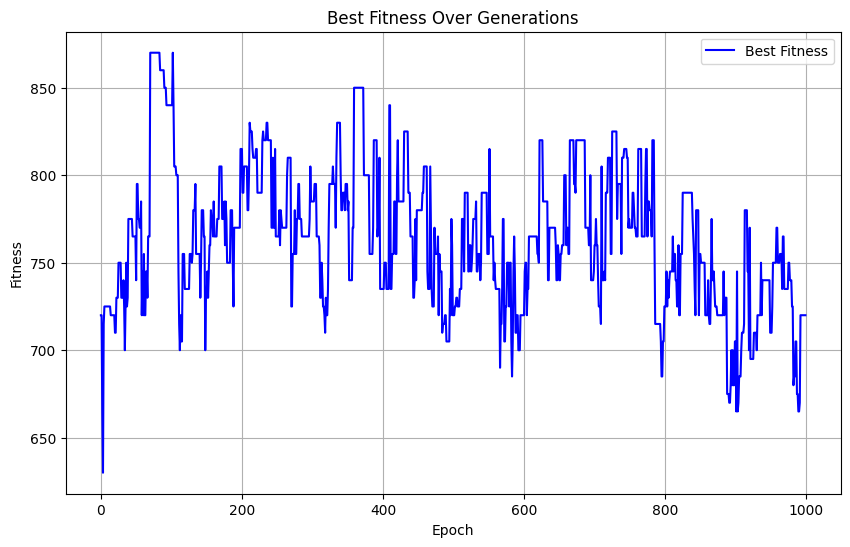

In [57]:
plt.figure(figsize=(10, 6))
plt.plot(df["Epoch"], df["Best_Fitness"], label="Best Fitness", color="blue")
plt.xlabel("Epoch")
plt.ylabel("Fitness")
plt.title("Best Fitness Over Generations")
plt.legend()
plt.grid()
plt.show()


### Trocando os hiperparametros para testar novas combinações

In [58]:

def tune_hyperparams(test_configs):
    experiment_results = []
    
    for config in test_configs:
        print(f"Rodando experimento com a configuração: {config}")
        
        data_log = evolve(
            epochs=config["geracoes"],
            chromosomes_len=config["cromossomos"],
            fathers_next_gen=int(config["taxa_pais"]),
            mutation_prob=config["prob_mutacao"],
            crossover_prob=config["prob_crossover"],
            random_state=config["random_state"]
        )
        
        experiment_results.append({
            "config": config,
            "data_log": data_log
        })
    
    # Ordenar os resultados pelos melhores fitness (última geração ou maior fitness)
    sorted_results = sorted(experiment_results, key=lambda x: x["data_log"][-1][1], reverse=True)
    
    
    for result in sorted_results:
        print(f"Configuração: {result['config']} | Melhor Fitness: {result['data_log'][-1][1]}")
    
    return sorted_results

test_configs = [
    {"cromossomos": 10, "tamanho": 10, "taxa_pais": 0.5, "prob_mutacao": 0.5, "prob_crossover": 0.5, "geracoes": 100, "random_state": 42},
    {"cromossomos": 20, "tamanho": 10, "taxa_pais": 0.5, "prob_mutacao": 0.5, "prob_crossover": 0.5, "geracoes": 100, "random_state": 42},
    {"cromossomos": 10, "tamanho": 10, "taxa_pais": 0.5, "prob_mutacao": 0.5, "prob_crossover": 0.5, "geracoes": 1000, "random_state": 42}
]


experiment_results = tune_hyperparams(test_configs)


Rodando experimento com a configuração: {'cromossomos': 10, 'tamanho': 10, 'taxa_pais': 0.5, 'prob_mutacao': 0.5, 'prob_crossover': 0.5, 'geracoes': 100, 'random_state': 42}
Epoch: 0 - Fitness: 570.0 - Chromossome: [1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0]
Epoch: 1 - Fitness: 630.0 - Chromossome: [1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0]
Epoch: 2 - Fitness: 745.0 - Chromossome: [1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0]
Epoch: 3 - Fitness: 735.0 - Chromossome: [1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0]
Epoch: 4 - Fitness: 735.0 - Chromossome: [1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0]
Epoch: 5 - Fitness: 735.0 - Chromossome: [1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0]
Epoch: 6 - Fitness: 735.0 - Chromossome: [1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0]
Epoch: 7 - Fitness: 735.0 - Chromossome: [1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0]
Epoch: 8 -

## Plotando o progresso